
# Data analysis and figure plotting for "Estimating the population-level effects of non-pharmaceutical interventions when transmission rates of COVID-19 vary by orders of magnitude from one contact to another" 

Richard Sear 2024 (r.sear@surrey.ac.uk)

Needs


1. 'iid3783-sup-0001-supplementary_table.xlsx'

2. '41586_2023_6952_MOESM3_ESM.csv'

3. 'Killingley2022_throat.csv'

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress
import pandas as pd
#from scipy.special import gamma
#from scipy.integrate import cumtrapz

plot of standard Wells-Riley (Poisson) function

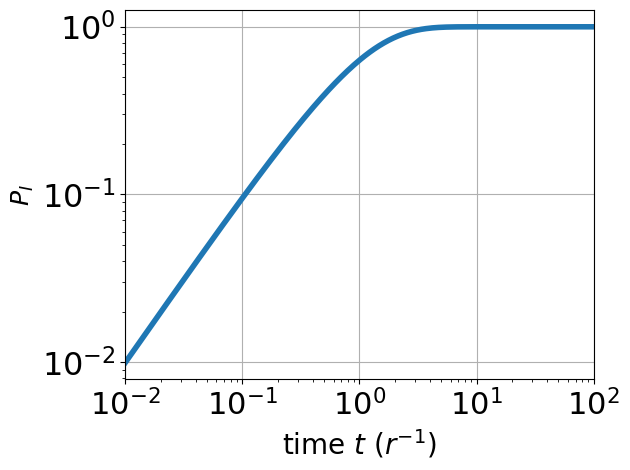

In [2]:
def WellsRiley(r,t):
    poft=1.0-np.exp(-r*t)
    return poft
#
tWR=np.geomspace(0.01,100,300)
#plt.semilogx(tWR,WellsRiley(1.0,tWR),lw=4)
plt.loglog(tWR,WellsRiley(1.0,tWR),lw=4)

plt.xticks(fontsize=22)
plt.yticks(fontsize=23)
#plt.xlim([1.0/6,100])
plt.ylabel('$P_I$',fontsize=18)
#plt.xlabel('RT-qPCR copies (min$^{-1}$)',fontsize=20)
plt.xlabel('time $t$ ($r^{-1}$)',fontsize=20)

plt.xlim([0.01,100.0])
plt.grid()
#plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('WellsRiley.pdf')
plt.show()

Now read in to RT-qPCR data on xlsx's from:

[Takatsuki 2023](https://onlinelibrary.wiley.com/doi/full/10.1002/iid3.783)

In [3]:
filename='iid3783-sup-0001-supplementary_table.xlsx'
df2=pd.read_excel(filename)
print(df2.head())
print(df2['Viral RNA\n(copies/μL)'])

   #  Type     Sex  Viral RNA\n(copies/μL)  Ct value
0  1  BA.1  Female                388687.0    16.900
1  2  BA.1  Female                  6656.0    23.300
2  3  BA.1  Female                188770.0    16.585
3  4  BA.1    Male                    21.0    32.976
4  5  BA.1  Female                   524.0    27.300
0      388687.0
1        6656.0
2      188770.0
3          21.0
4         524.0
         ...   
685        67.0
686    172385.0
687       389.0
688        13.0
689    330438.0
Name: Viral RNA\n(copies/μL), Length: 690, dtype: float64


count numbers of qPCR meassurements from samples

In [4]:

listty2=df2['Viral RNA\n(copies/μL)'].tolist()

#print(len(listty2))
qPCRvalues2=[]
for i in range(0,len(listty2)):
# convert to per ml
    qPCRvalues2.append(listty2[i]*1000.0)
#
count2=len(qPCRvalues2)
print(count2, ' qPCR values from Takatsuki ')
qPCRvalues2=np.sort(np.array(qPCRvalues2))
#
print('min and max Takatsuki ',np.min(qPCRvalues2), np.max(qPCRvalues2), ' dynamic range', \
      np.log10(np.max(qPCRvalues2)/np.min(qPCRvalues2)))


690  qPCR values from Takatsuki 
min and max Takatsuki  500.0 57142000000.0  dynamic range 8.0579854325116


Directly compute exceedances (cumulative distribution functions)

In [5]:
def ecdf(data):
# Compute Exceedance CDF
    n = len(data)
    y = 1.0-np.arange(1, n+1) / n
    return y
#
exceedance2=ecdf(qPCRvalues2)
#


In [6]:
def fit_partial_data(x,y):
    lnxdata_to_fit=[]
    lnydata_to_fit=[]
    for i in range(0,len(x)-1):
        if(x[i]>qPCR_min):
            lnxdata_to_fit.append(np.log(x[i]))
            lnydata_to_fit.append(np.log(y[i]))
#
    print('fitting to ',len(lnxdata_to_fit),'points')
    linreg_out=linregress(lnxdata_to_fit,lnydata_to_fit)
    return lnxdata_to_fit,lnydata_to_fit,linreg_out
#
qPCR_min=1.0e8


print('')
print(' fitting to tail of Takatsuki data, above ',qPCR_min)
lnxdata_to_fit,lnydata_to_fit,linreg_out=fit_partial_data(qPCRvalues2,exceedance2)
print(linreg_out)
beta=linreg_out.slope
coef=linreg_out.intercept
log_dose_plot2=np.linspace(np.min(lnxdata_to_fit),np.max(lnxdata_to_fit),100)
print(np.min(lnxdata_to_fit),np.max(lnxdata_to_fit))
powerlaw_fit2=np.exp(coef+beta*log_dose_plot2)


 fitting to tail of Takatsuki data, above  100000000.0
fitting to  282 points
LinregressResult(slope=-0.6965231190484855, intercept=12.113940476370853, rvalue=-0.9877257775711131, pvalue=8.172645276618222e-228, stderr=0.006582568116216541, intercept_stderr=0.1325703243862674)
18.432866198816168 24.65435423719733


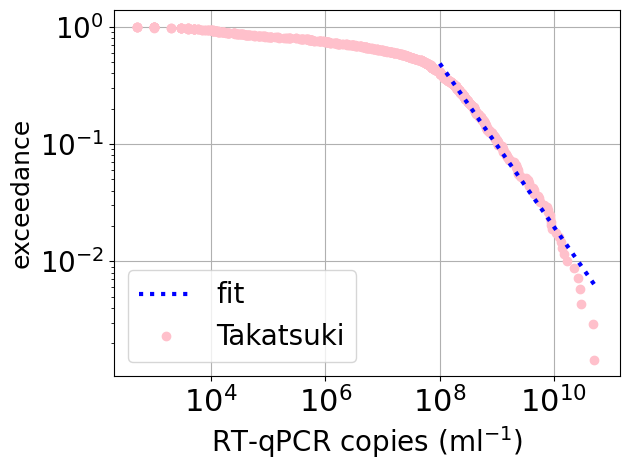

In [7]:
plt.loglog(np.exp(log_dose_plot2),powerlaw_fit2,zorder=11,lw=3,color='blue',ls=':',label='fit')
#
plt.loglog(qPCRvalues2,exceedance2,lw=0,marker='o',markersize=6,label='Takatsuki',c='pink')


plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
#plt.xlim([1.0/6,100])
plt.ylabel('exceedance',fontsize=18)
plt.xlabel('RT-qPCR copies (ml$^{-1}$)',fontsize=20)

#plt.ylim([0.01,0.3])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('exceedance.pdf')
plt.show()

### Now read in data from NHS app and fit to it


[Webpage on paper at U Oxford](https://045.medsci.ox.ac.uk/risk_measurement) and [Nature paper of Ferretti *et al*](https://www.nature.com/articles/s41586-023-06952-2)

In [8]:
filename='41586_2023_6952_MOESM3_ESM.csv'
df3=pd.read_csv(filename)
print(df3.head())
listty4=df3['meanscore'].tolist()
listty5=df3['probability_of_reported_infection'].tolist()
contact_time_data=np.array(listty4[30:])
Pi_data=np.array(listty5[30:])
print(contact_time_data)
print(Pi_data)
print('number of data points = ',len(contact_time_data))
#print(df3['Viral RNA\n(copies/μL)'])

          which_score        n  meanscore  probability_of_reported_infection  \
0  maximum risk score  2037583   1.195917                           0.019232   
1  maximum risk score  1450139   1.393795                           0.021291   
2  maximum risk score  1020279   1.624996                           0.024121   
3  maximum risk score   714550   1.894369                           0.028036   
4  maximum risk score   500823   2.208692                           0.033625   

    upperCI   lowerCI  
0  0.019421  0.019043  
1  0.021526  0.021057  
2  0.024419  0.023824  
3  0.028419  0.027654  
4  0.034124  0.033125  
[ 0.32359969  0.46169268  0.84311884  1.2425773   1.8356923   2.73472183
  4.20280909  6.37572807  9.77015173 14.97065133 22.89100291 34.8908658
 52.58697072 83.2305573 ]
[0.01898455 0.01851172 0.02280926 0.03109047 0.03551651 0.04256574
 0.05238726 0.06197496 0.07879814 0.09999239 0.13338477 0.16417206
 0.18935967 0.20323689]
number of data points =  14


LinregressResult(slope=0.4743661975481525, intercept=-3.593539608033808, rvalue=0.9956834876590172, pvalue=9.252720190559493e-14, stderr=0.01276480344908973, intercept_stderr=0.030324461983469084)
[0.01898455 0.01851172 0.02280926 0.03109047 0.03551651 0.04256574
 0.05238726 0.06197496 0.07879814 0.09999239 0.13338477 0.16417206
 0.18935967 0.20323689]
[ 0.00288143 -0.00054841 -0.00255311  0.00060524 -0.00116805 -0.00175453
 -0.00195426 -0.00424475 -0.00228327  0.00071736  0.01195516  0.01586703
  0.00919402 -0.02077075]
[ 0.15177781 -0.02962503 -0.11193287  0.01946713 -0.03288752 -0.04121926
 -0.03730405 -0.0684914  -0.02897622  0.00717412  0.08962913  0.09664877
  0.04855319 -0.10219971]


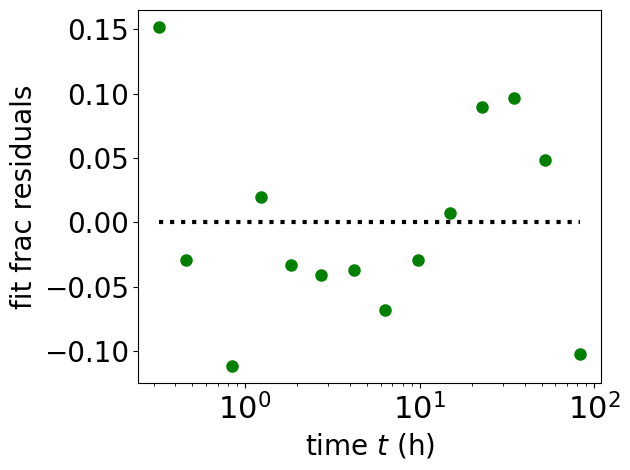

-2.810848428221006 9.282738909153089 0.07996515553967087
R^2  0.9913856075968244


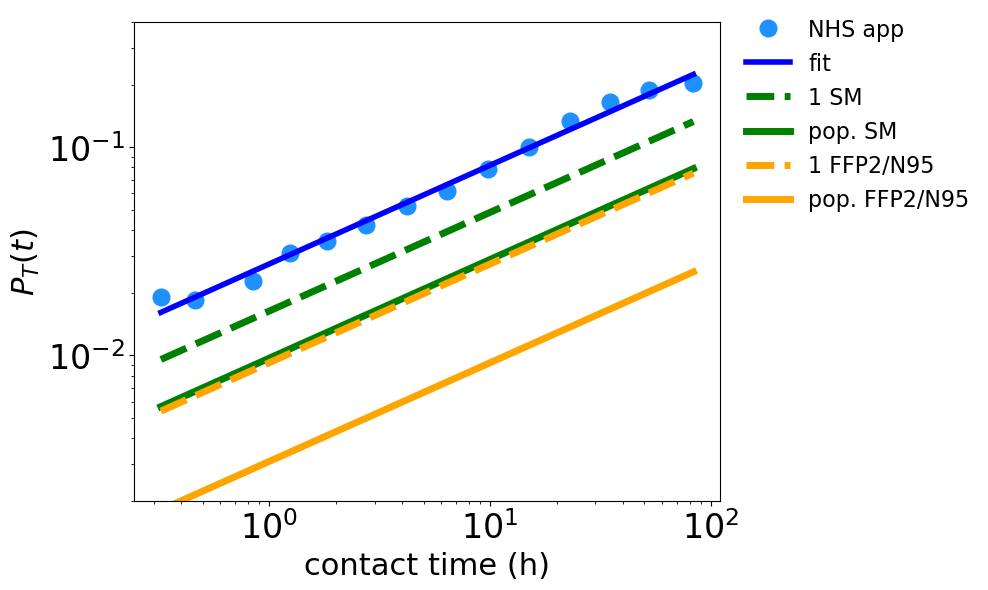

In [9]:
n_fitpts=14
linreg_out=linregress(np.log(contact_time_data[0:n_fitpts]),np.log(Pi_data[0:n_fitpts]))
print(linreg_out)
beta=linreg_out.slope
coef=linreg_out.intercept
log_dose_plot=np.linspace(np.log(np.min(contact_time_data)), \
                          np.log(np.max(contact_time_data)),100)
powerlaw_fit=np.exp(coef+beta*log_dose_plot)


#
residuals=Pi_data[0:n_fitpts]-np.exp(coef+beta*np.log(contact_time_data[0:n_fitpts]))
log_residuals=np.log(Pi_data[0:n_fitpts])-coef-beta*np.log(contact_time_data[0:n_fitpts])
print(Pi_data)
print(residuals)
print(residuals/Pi_data)
#
#plt.loglog(dose_data[0:n_fitpts],np.abs(residuals) \
#           ,lw=0,marker='o',ms=8,c='g',label='res')
plt.semilogx(contact_time_data[0:n_fitpts],residuals/Pi_data \
           ,lw=0,marker='o',ms=8,c='g',label='res')
plt.semilogx([contact_time_data[0],contact_time_data[n_fitpts-1]],[0,0],lw=3,c='k',ls=':')
plt.ylabel('fit frac residuals',fontsize=20)
plt.xlabel('time $t$ (h)',fontsize=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('residuals.pdf')
plt.show()
# compute R sq
mean_y=np.mean(np.log(Pi_data[0:n_fitpts]))
sum_sqs=np.sum((np.log(Pi_data[0:n_fitpts])-mean_y)**2)
sum_sq_res=np.sum(log_residuals**2)
print(mean_y,sum_sqs,sum_sq_res)
Rsquared=1.0-sum_sq_res/sum_sqs
print('R^2 ',Rsquared)
# TOC figure
plt.figure(figsize=(10,6))
plt.loglog(contact_time_data[0:n_fitpts],Pi_data[0:n_fitpts],lw=0,marker='o',ms=12,c='dodgerblue',label='NHS app',zorder=2)
plt.loglog(np.exp(log_dose_plot),powerlaw_fit,lw=4,c='b',label='fit')
plt.loglog(np.exp(log_dose_plot),powerlaw_fit*((1.0/3.0)**beta),lw=5,c='green',label='1 SM',ls='--', dashes=(4, 1.5) )
plt.loglog(np.exp(log_dose_plot),powerlaw_fit*(((1.0/3.0)**2)**beta),lw=5,c='green',label='pop. SM')
plt.loglog(np.exp(log_dose_plot),powerlaw_fit*(0.1**beta),lw=5,c='orange',label='1 FFP2/N95',ls='--', dashes=(4, 1.5))
plt.loglog(np.exp(log_dose_plot),powerlaw_fit*((0.1**2)**beta),lw=5,c='orange',label='pop. FFP2/N95')


#m=0.1
#c=0.0
#y=(m*np.exp(log_dose_plot)+c)/30.0
#plt.loglog(np.exp(log_dose_plot),y,lw=3,ls=':',c='orange')

plt.legend(fontsize=16,frameon=False,bbox_to_anchor=(1.01, 1.05))
plt.ylabel('$P_T(t)$',fontsize=22)
plt.xlabel('contact time (h)',fontsize=22)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim([0.002,.4])
#plt.grid()
plt.tight_layout()
plt.savefig('ferretti.pdf')
plt.show()

In [10]:
rng = np.random.default_rng()
time_fit=[]
Pi_fit=[]
time_test=[]
Pi_test=[]
n_fit=0
n_test=0
for i in range(0,n_fitpts):
    if(rng.random()>0.5):  
        time_fit.append(contact_time_data[i])
        Pi_fit.append(Pi_data[i])
        n_fit=n_fit+1
    else:
        time_test.append(contact_time_data[i])
        Pi_test.append(Pi_data[i])
        n_test=n_test+1
time_fit=np.array(time_fit)
Pi_fit=np.array(Pi_fit)
time_test=np.array(time_test)
Pi_test=np.array(Pi_test)
#
print('fitting to ',n_fit,' points w test on ',n_test,' points')
linreg_out_ML=linregress(np.log(time_fit),np.log(Pi_fit))
print(linreg_out_ML)
beta_ML=linreg_out.slope
coef_ML=linreg_out.intercept
# test
Pi_ratio_error=np.zeros(n_test)
for i in range(0,n_test):
    Pi_predict=np.exp(coef_ML+beta_ML*np.log(time_test[i]))
    Pi_ratio_error[i]=Pi_predict/Pi_test[i]-1
    print('predicted P_I ',Pi_predict,' data P_I ',Pi_test[i],' frac error ',Pi_ratio_error[i])
mean_ratio_error=np.sqrt(np.mean(Pi_ratio_error**2))
print('mean ratio error ',mean_ratio_error)

fitting to  6  points w test on  8  points
LinregressResult(slope=0.4647739682565158, intercept=-3.5709789527395253, rvalue=0.992620493726695, pvalue=8.148473595371498e-05, stderr=0.028389288732874076, intercept_stderr=0.04705635472758778)
predicted P_I  0.025362363765466873  data P_I  0.022809258  frac error  0.11193287240939065
predicted P_I  0.030485225860516548  data P_I  0.031090468  frac error  -0.01946712862229838
predicted P_I  0.05434151180812643  data P_I  0.052387255  frac error  0.03730405053913266
predicted P_I  0.08108141089538276  data P_I  0.078798139  frac error  0.02897621599137956
predicted P_I  0.0992750324591055  data P_I  0.09999239  frac error  -0.007174121359580399
predicted P_I  0.1483050305854861  data P_I  0.164172058  frac error  -0.09664876963724178
predicted P_I  0.18016565464008652  data P_I  0.18935967  frac error  -0.04855318643042361
predicted P_I  0.22400763917427863  data P_I  0.203236888  frac error  0.10219971078418899
mean ratio error  0.068313428

Now for comparison of qPCR measurements and measurements of infectious virus. First read in data from [Killingley et al](https://www.nature.com/articles/s41591-022-01780-9)

In [11]:
datain=np.loadtxt('Killingley2022_throat.csv',delimiter=',')
log10FFA=datain[:,0]
log10qPCR=datain[:,1]
print(log10FFA,log10qPCR)

[2.09678227 2.39925713 2.34253161 2.45703435 2.53901757 2.71884312
 2.73567046 2.84244397 2.83444764 2.67108218 3.36666249 3.27666625
 3.2854138  3.91480322 3.90845958 2.98429114 3.9498435  4.40194483] [7.24489796 7.17755102 7.37346939 7.36734694 7.43469388 7.38571429
 7.55714286 7.71632653 7.78367347 7.86938776 7.97346939 7.96734694
 8.1755102  8.00408163 8.67755102 8.73877551 8.85510204 9.66326531]


LinregressResult(slope=0.8513947096468593, intercept=-3.7219283437210255, rvalue=0.8708381425061087, pvalue=2.5770183479752918e-06, stderr=0.12014861309641016, intercept_stderr=0.9574506721848927)


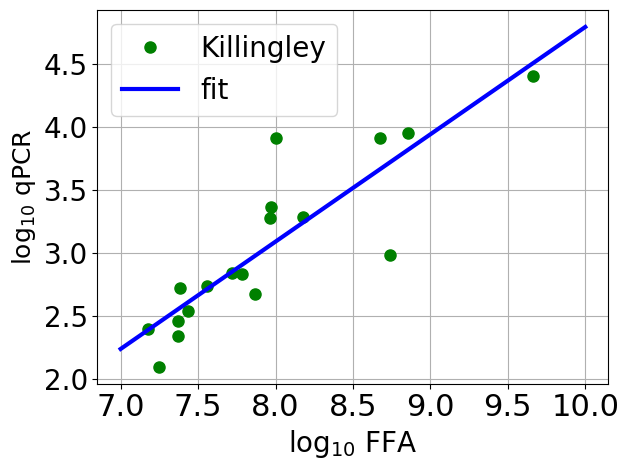

In [12]:
linreg_out=linregress(log10qPCR,log10FFA)
print(linreg_out)
beta=linreg_out.slope
coef=linreg_out.intercept
log10qPCR_plot=np.linspace(7.0,10.0,100)


plt.plot(log10qPCR,log10FFA,lw=0,marker='o',ms=8,c='g',label='Killingley')
plt.plot(log10qPCR_plot,coef+beta*log10qPCR_plot,lw=3,c='b',label='fit')
plt.grid()

plt.legend(fontsize=20)
plt.ylabel('log$_{10}$ qPCR',fontsize=18)
plt.xlabel('log$_{10}$ FFA',fontsize=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
#plt.xlim([1.0,800])
plt.tight_layout()
plt.savefig('killingley.pdf')
plt.show()

Laplace transform of $p(r)$ from Johnson's [2006 PRB](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.74.184430)

In [13]:
def laplace_sqrtPL(S):
    p=np.exp(-1.0/(4.0*S))/np.sqrt(4.0*np.pi*S**3)
    return p
#
def contribution_sqrtPL(S,contact_time1):
    pS=laplace_sqrtPL(S)
    contrib=pS*(1.0-np.exp(-S*contact_time1))
    return contrib
#
S=np.geomspace(1.0e-2,10000,1000)
laplace_sqrt=laplace_sqrtPL(S)
contrib_sqrt_1=contribution_sqrtPL(S,0.1)

Transform in terms of times (not rates) from [Lindsey and Patterson](https://doi.org/10.1063/1.440530)

In [14]:
n_pts=200
rho_of_tau=np.zeros(n_pts)
tau=np.geomspace(1.0e-2,1.0e2,n_pts)
tau_scale=1.0

# beta 1/2 special case


rho_of_tau_half=np.exp(-0.25*tau/tau_scale)
rho_of_tau_half=rho_of_tau_half/np.sqrt(tau*tau_scale)
rho_of_tau_half=rho_of_tau_half/(2.0*np.sqrt(np.pi))

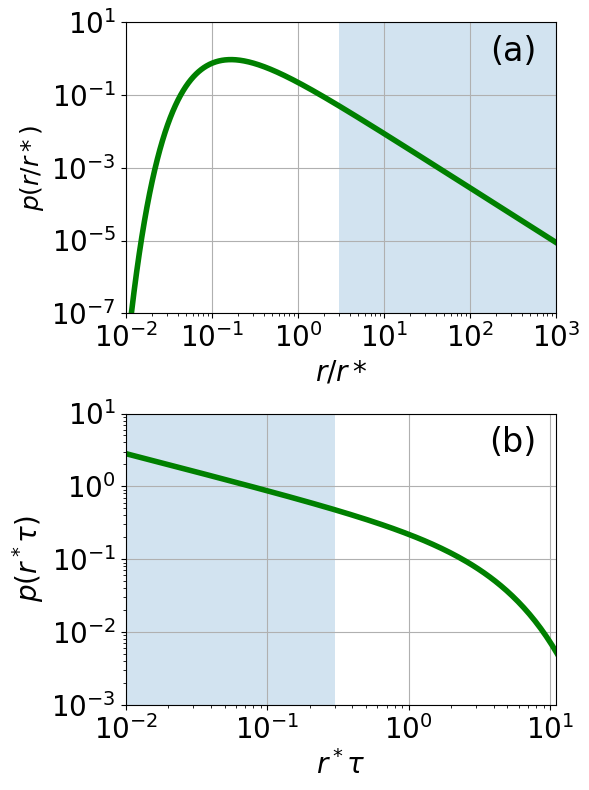

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(6,8))

#
axs[0].loglog(S,laplace_sqrt,lw=4,c='green',label='$p(r/r*)$')
#axs[0].loglog(S,contrib_sqrt_1,lw=4,c='cyan',label='contributions')
xfill=np.geomspace(3.0,3.0e3,10)
yfill_min=np.ones(10)*1.0e-8
yfill_max=np.ones(10)*100.0
axs[0].fill_between(xfill,yfill_min,yfill_max,alpha=0.2)
axs[0].grid(True)

axs[0].set_ylabel('$p(r/r*)$',fontsize=18)
axs[0].set_xlabel('$r/r*$',fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_xlim([1.0e-2,1000])
axs[0].set_ylim([1.0e-07,10])
#axs[0].legend(fontsize=20)
#
axs[1].loglog(tau,rho_of_tau_half,lw=4,color='green')
axs[1].set_ylabel('$p(r^*\\tau)$',fontsize=20)
axs[1].set_xlabel('$r^*\\tau$',fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
xfill=np.geomspace(3.0e-3,3.0e-1,10)
yfill_min=np.ones(10)*1.0e-8
yfill_max=np.ones(10)*100.0
axs[1].fill_between(xfill,yfill_min,yfill_max,alpha=0.2)
axs[1].grid(True)

axs[1].set_xlim([1.0e-2,11])
axs[1].set_ylim([1.0e-03,10])
#plt.legend(fontsize=20)
#
axs[0].text(0.9, 0.9, '(a)', horizontalalignment='center',\
            verticalalignment='center', transform=axs[0].transAxes,fontsize=24)
axs[1].text(0.9, 0.9, '(b)', horizontalalignment='center', \
            verticalalignment='center', transform=axs[1].transAxes,fontsize=24)

#
plt.tight_layout()
plt.savefig('laplace.pdf')
plt.show()